In [ ]:
pip uninstall tensorflow

Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.16.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.16.1


In [ ]:
pip install tensorflow==2.15.0

persiapan dataset

In [ ]:
import os
from google.colab import files

# Unggah kaggle.json Anda
files.upload()

# Instal library kaggle dan konfigurasi
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Unduh dataset dari Kaggle
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset
!unzip corn-or-maize-leaf-disease-dataset.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 95% 152M/161M [00:01<00:00, 137MB/s]
100% 161M/161M [00:01<00:00, 92.5MB/s]
Archive:  corn-or-maize-leaf-disease-dataset.zip
  inflating: data/Blight/Corn_Blight (1).jpeg  
  inflating: data/Blight/Corn_Blight (1).jpg  
  inflating: data/Blight/Corn_Blight (10).jpg  
  inflating: data/Blight/Corn_Blight (100).jpg  
  inflating: data/Blight/Corn_Blight (1000).JPG  
  inflating: data/Blight/Corn_Blight (1001).JPG  
  inflating: data/Blight/Corn_Blight (1002).JPG  
  inflating: data/Blight/Corn_Blight (1003).JPG  
  inflating: data/Blight/Corn_Blight (1004).JPG  
  inflating: data/Blight/Corn_Blight (1005).JPG  
  inflating: data/Blight/Corn_Blight (1006).JPG  
  inflating: data/Blight/Corn_Blight (1007).JPG  
  inflating: data/Blight/Corn_Blight (1008).JPG  
  inflating: data/Blight/Corn_Blight (1009).JPG  
  inflating: data/Bligh

run lib

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


membuat generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tentukan direktori dataset
base_dir = 'data'

# Tentukan ukuran gambar yang diharapkan
image_size = (224, 224)

# Buat generator gambar untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data pelatihan
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=20,
    class_mode='categorical',
    subset='training'
)

# Generator untuk data validasi
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=20,
    class_mode='categorical',
    subset='validation'
)

# Tambahkan .repeat() pada generator
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32))
).repeat()

validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32))
).repeat()


Found 3352 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


melatih model menggunakan mobilenet

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Define the input layer with a valid name
input_layer = Input(shape=(224, 224, 3), name='input_image')

# Add custom layers on top
model = Sequential([
    input_layer,
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')  # Adjust the number of classes to 4
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Calculate steps per epoch and validation steps
steps_per_epoch = (train_generator.samples + train_generator.batch_size - 1) // train_generator.batch_size
validation_steps = (validation_generator.samples + validation_generator.batch_size - 1) // validation_generator.batch_size

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Load the best model
model.load_weights('best_model.keras')


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
168/168 [==============================] - 215s 1s/step - loss: 0.3485 - accuracy: 0.8732 - val_loss: 0.5148 - val_accuracy: 0.8301
Epoch 2/10
168/168 [==============================] - 248s 1s/step - loss: 0.2678 - accuracy: 0.8983 - val_loss: 0.2277 - val_accuracy: 0.8983
Epoch 3/10
168/168 [==============================] - 254s 2s/step - loss: 0.2434 - accuracy: 0.8995 - val_loss: 0.2037 - val_accuracy: 0.9187
Epoch 4/10
168/168 [==============================] - 209s 1s/step - loss: 0.2131 - accuracy: 0.9090 - val_loss: 0.2167 - val_accuracy: 0.9079
Epoch 5/10
168/168 [==============================] - 252s 2s/step - loss: 0.2032 - accuracy: 0.9153 - val_loss: 0.2172 - val_accuracy: 0.9103
Epoch 6/10
168/168 [==============================] - 249s 1s/step - loss: 0.1752 - accuracy: 0.9281 - val_loss: 0.2421 - val_accuracy: 0.8995


fine tuning

In [ ]:
# Fine-tuning the model
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model again
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs = 10 + fine_tune_epochs

# Fine-tune the model
history_fine = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=total_epochs,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Load the best fine-tuned model
model.load_weights('best_model.keras')


Epoch 1/20
168/168 [==============================] - 287s 2s/step - loss: 0.3823 - accuracy: 0.8520 - val_loss: 0.2870 - val_accuracy: 0.8923
Epoch 2/20
168/168 [==============================] - 278s 2s/step - loss: 0.2773 - accuracy: 0.8920 - val_loss: 0.3503 - val_accuracy: 0.8696
Epoch 3/20
168/168 [==============================] - 280s 2s/step - loss: 0.2470 - accuracy: 0.9084 - val_loss: 0.2723 - val_accuracy: 0.8923
Epoch 4/20
168/168 [==============================] - 275s 2s/step - loss: 0.2286 - accuracy: 0.9117 - val_loss: 0.2652 - val_accuracy: 0.9031
Epoch 5/20
168/168 [==============================] - 269s 2s/step - loss: 0.2118 - accuracy: 0.9195 - val_loss: 0.2645 - val_accuracy: 0.9067
Epoch 6/20
168/168 [==============================] - 270s 2s/step - loss: 0.2075 - accuracy: 0.9195 - val_loss: 0.2453 - val_accuracy: 0.9079
Epoch 7/20
168/168 [==============================] - 272s 2s/step - loss: 0.1929 - accuracy: 0.9257 - val_loss: 0.1778 - val_accuracy: 0.9366

test

42/42 [==============================] - 38s 869ms/step - loss: 0.1925 - accuracy: 0.9306
Validation loss: 0.19254711270332336
Validation accuracy: 0.9306219816207886
1/1 [==============================] - 2s 2s/step


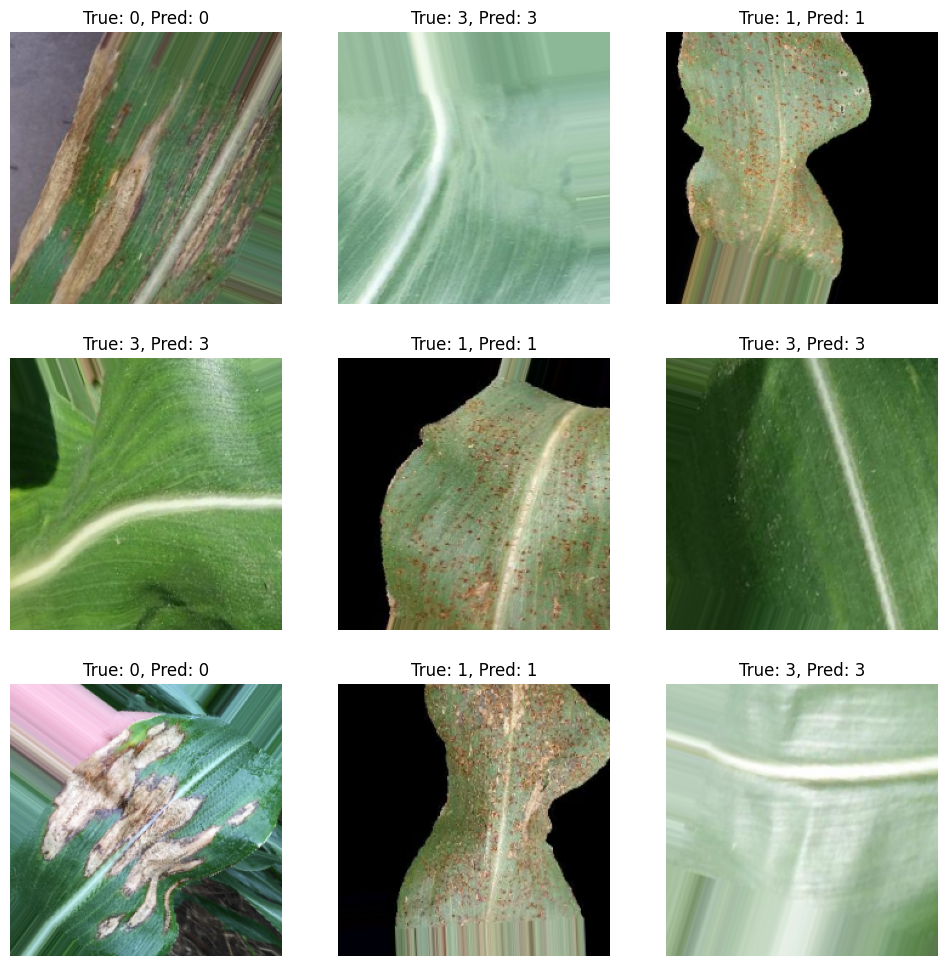

In [ ]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation loss: {val_loss}')
print(f'Validation accuracy: {val_accuracy}')

# Optionally, you can also evaluate the model on a separate test set if you have one
# test_generator = test_datagen.flow_from_directory(
#     'path/to/test/data',
#     target_size=image_size,
#     batch_size=20,
#     class_mode='categorical'
# )

# test_loss, test_accuracy = model.evaluate(test_generator)
# print(f'Test loss: {test_loss}')
# print(f'Test accuracy: {test_accuracy}')

# Predict on a batch of validation data and show some examples
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of images and labels
x_batch, y_batch = next(validation_generator)

# Predict the probabilities for each class
predictions = model.predict(x_batch)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_batch, axis=1)

# Plot some examples with their predicted and true labels
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'True: {true_classes[i]}, Pred: {predicted_classes[i]}')
    plt.axis('off')
plt.show()


1/1 [==============================] - 1s 585ms/step


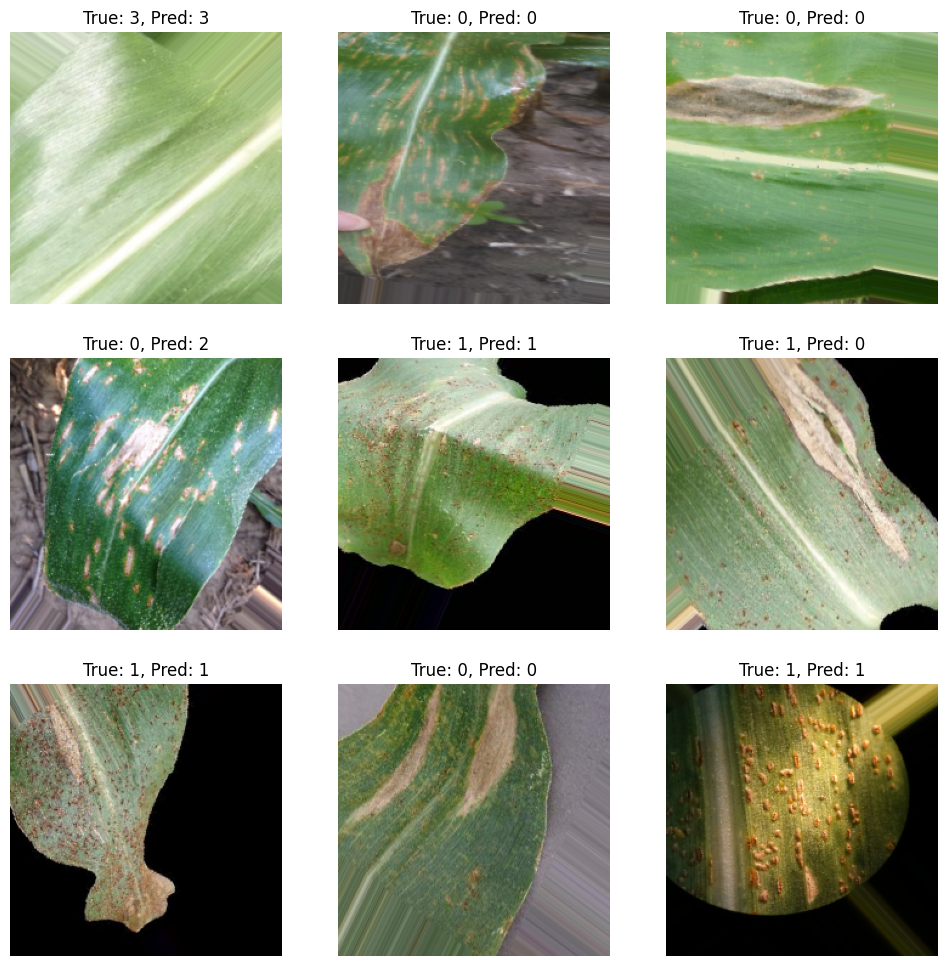

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Mendapatkan batch gambar dan label
x_batch, y_batch = next(validation_generator)

# Memprediksi probabilitas untuk setiap kelas
predictions = model.predict(x_batch)

# Mengubah prediksi menjadi label kelas
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_batch, axis=1)

# Menampilkan beberapa contoh dengan label sebenarnya dan prediksi
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'True: {true_classes[i]}, Pred: {predicted_classes[i]}')
    plt.axis('off')
plt.show()


In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy:.2f}')


42/42 [==============================] - 38s 875ms/step - loss: 0.1718 - accuracy: 0.9330
Validation accuracy: 0.93


Bagian 5: Evaluasi dan Konversi Model ke TensorFlow Lite

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

try:
    # Load the model
    model_path = 'best_model.keras'
    model = load_model(model_path, compile=False)

    # Convert the model to TensorFlow Lite format with optimization
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()

    # Save the converted model to a .tflite file
    tflite_model_path = 'model_optimized.tflite'
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

    # Optional: Download the TensorFlow Lite model (if running in Google Colab)
    from google.colab import files
    files.download(tflite_model_path)

    print(f'Model has been converted and saved to {tflite_model_path}')
except Exception as e:
    print(f'Error occurred: {e}')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model has been converted and saved to model_optimized.tflite


test1

Saving Corn_Blight (1021).JPG to Corn_Blight (1021) (1).JPG
1/1 [==============================] - 0s 63ms/step


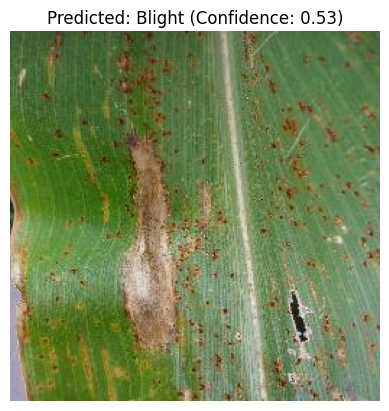

Predictions completed.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Buat batch tunggal
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Fungsi untuk memprediksi label gambar dan menampilkan hasil
def predict_image(model, img_path, class_names):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class

# Path ke folder gambar tes dan class names
class_names = ['Blight', 'Common_Rust', 'Gray_leaf_spot', 'Healthy']  # Ganti dengan nama-nama kelas sesuai model Anda

# Memuat model
model.load_weights('best_model.keras')

# Mengunggah gambar
uploaded = files.upload()

# Inisialisasi list untuk menyimpan label asli dan prediksi
predicted_labels = []

# Menguji semua gambar yang diunggah
for img_name in uploaded.keys():
    img_path = img_name
    predicted_class = predict_image(model, img_path, class_names)
    predicted_labels.append(predicted_class)

print("Predictions completed.")


test2

Saving Corn_Common_Rust (1037).JPG to Corn_Common_Rust (1037).JPG
1/1 [==============================] - 0s 52ms/step


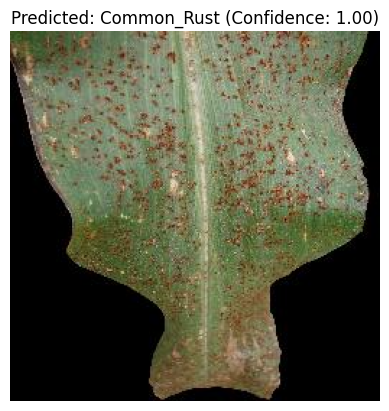

Predictions completed.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Buat batch tunggal
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Fungsi untuk memprediksi label gambar dan menampilkan hasil
def predict_image(model, img_path, class_names):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class

# Path ke folder gambar tes dan class names
class_names = ['Healthy', 'Common_Rust', 'Gray_leaf_spot', 'Blight']  # Ganti dengan nama-nama kelas sesuai model Anda

# Memuat model
model.load_weights('best_model.keras')

# Mengunggah gambar
uploaded = files.upload()

# Inisialisasi list untuk menyimpan label asli dan prediksi
predicted_labels = []

# Menguji semua gambar yang diunggah
for img_name in uploaded.keys():
    img_path = img_name
    predicted_class = predict_image(model, img_path, class_names)
    predicted_labels.append(predicted_class)

print("Predictions completed.")


test3

Saving corn-leaf-592580_960_720.jpg to corn-leaf-592580_960_720 (1).jpg
1/1 [==============================] - 0s 82ms/step


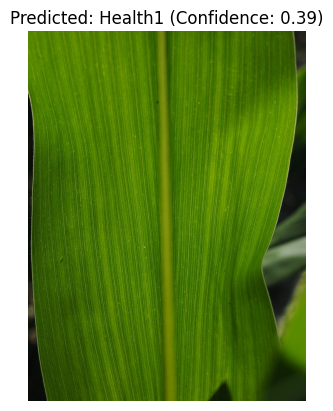

Predictions completed.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Buat batch tunggal
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Fungsi untuk memprediksi label gambar dan menampilkan hasil
def predict_image(model, img_path, class_names):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class

# Path ke folder gambar tes dan class names
class_names = ['Blight', 'Healthy1', 'Gray_leaf_spot', 'Healthy']  # Ganti dengan nama-nama kelas sesuai model Anda

# Memuat model
model.load_weights('best_model.keras')

# Mengunggah gambar
uploaded = files.upload()

# Inisialisasi list untuk menyimpan label asli dan prediksi
predicted_labels = []

# Menguji semua gambar yang diunggah
for img_name in uploaded.keys():
    img_path = img_name
    predicted_class = predict_image(model, img_path, class_names)
    predicted_labels.append(predicted_class)

print("Predictions completed.")


Found 3352 images belonging to 4 classes.
Found 836 images belonging to 4 classes.
Class Indices:  {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
Class Names:  ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


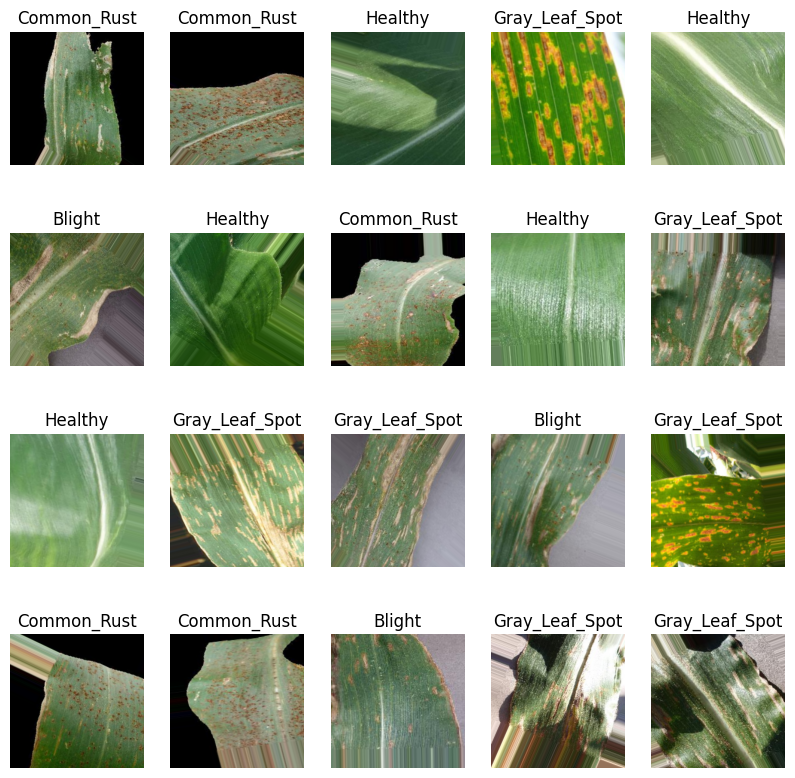

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Tentukan direktori dataset
base_dir = 'data'

# Tentukan ukuran gambar yang diharapkan
image_size = (224, 224)

# Buat generator gambar untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data pelatihan
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=20,
    class_mode='categorical',
    subset='training'
)

# Generator untuk data validasi
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=20,
    class_mode='categorical',
    subset='validation'
)

# Mendapatkan mapping nama kelas ke indeks
class_indices = train_generator.class_indices
print("Class Indices: ", class_indices)

# Mendapatkan mapping indeks ke nama kelas
class_names = list(class_indices.keys())
print("Class Names: ", class_names)

# Tambahkan .repeat() pada generator
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32))
).repeat()

validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32))
).repeat()

# Fungsi untuk menampilkan batch gambar dan labelnya
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(20):
        ax = plt.subplot(4, 5, n + 1)
        plt.imshow(image_batch[n])
        label_index = tf.argmax(label_batch[n]).numpy()
        plt.title(class_names[label_index])
        plt.axis('off')

# Mendapatkan satu batch gambar dari generator
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)


test6

Saving Corn_Health (1000).jpg to Corn_Health (1000).jpg
1/1 [==============================] - 0s 92ms/step


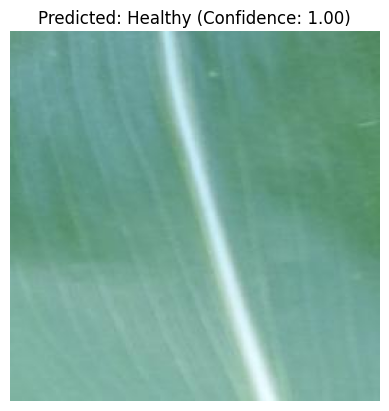

Predictions completed.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Buat batch tunggal
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Fungsi untuk memprediksi label gambar dan menampilkan hasil
def predict_image(model, img_path, class_names):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class

# Path ke folder gambar tes dan class names
class_names = ['Blight', 'Common_Rust', 'Gray_leaf_spot', 'Healthy']  # Ganti dengan nama-nama kelas sesuai model Anda

# Memuat model
model.load_weights('best_model.keras')

# Mengunggah gambar
uploaded = files.upload()

# Inisialisasi list untuk menyimpan label asli dan prediksi
predicted_labels = []

# Menguji semua gambar yang diunggah
for img_name in uploaded.keys():
    img_path = img_name
    predicted_class = predict_image(model, img_path, class_names)
    predicted_labels.append(predicted_class)

print("Predictions completed.")


Saving Corn_Health (1).jpg to Corn_Health (1) (1).jpg
1/1 [==============================] - 0s 68ms/step


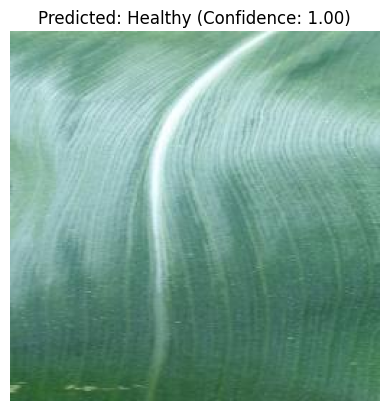

Predictions completed.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Buat batch tunggal
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Fungsi untuk memprediksi label gambar dan menampilkan hasil
def predict_image(model, img_path, class_names):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class

# Path ke folder gambar tes dan class names
class_names = ['Blight', 'Common_Rust', 'Gray_leaf_spot', 'Healthy']  # Ganti dengan nama-nama kelas sesuai model Anda

# Memuat model
model.load_weights('best_model.keras')

# Mengunggah gambar
uploaded = files.upload()

# Inisialisasi list untuk menyimpan label asli dan prediksi
predicted_labels = []

# Menguji semua gambar yang diunggah
for img_name in uploaded.keys():
    img_path = img_name
    predicted_class = predict_image(model, img_path, class_names)
    predicted_labels.append(predicted_class)

print("Predictions completed.")


Saving Corn_Blight (1006).JPG to Corn_Blight (1006).JPG
1/1 [==============================] - 0s 57ms/step


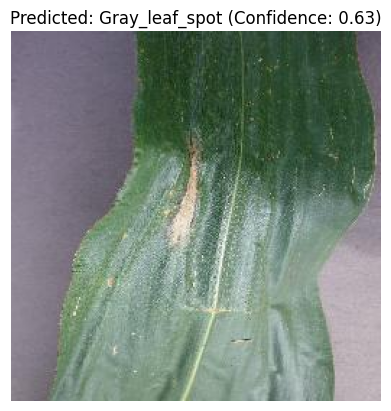

Predictions completed.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Buat batch tunggal
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Fungsi untuk memprediksi label gambar dan menampilkan hasil
def predict_image(model, img_path, class_names):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class

# Path ke folder gambar tes dan class names
class_names = ['Healthy', 'Common_rust', 'Gray_leaf_spot', 'Blight']  # Ganti dengan nama-nama kelas sesuai model Anda

# Memuat model
model.load_weights('best_model.keras')

# Mengunggah gambar
uploaded = files.upload()

# Inisialisasi list untuk menyimpan label asli dan prediksi
predicted_labels = []

# Menguji semua gambar yang diunggah
for img_name in uploaded.keys():
    img_path = img_name
    predicted_class = predict_image(model, img_path, class_names)
    predicted_labels.append(predicted_class)

print("Predictions completed.")


Saving northern-leaf-spot-of-maize-1.jpg to northern-leaf-spot-of-maize-1.jpg
1/1 [==============================] - 0s 56ms/step


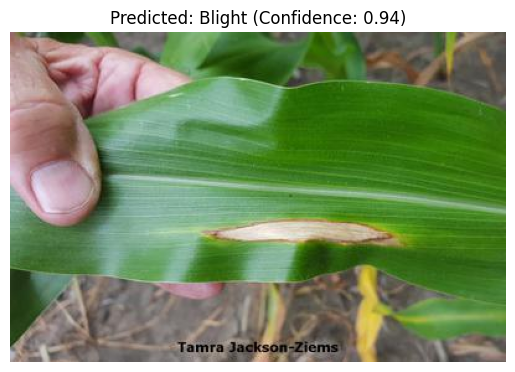

Predictions completed.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Buat batch tunggal
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Fungsi untuk memprediksi label gambar dan menampilkan hasil
def predict_image(model, img_path, class_names):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class

# Path ke folder gambar tes dan class names
class_names = ['Blight', 'Common_Rust', 'Gray_leaf_spot', 'Healthy']  # Ganti dengan nama-nama kelas sesuai model Anda

# Memuat model
model.load_weights('best_model.keras')

# Mengunggah gambar
uploaded = files.upload()

# Inisialisasi list untuk menyimpan label asli dan prediksi
predicted_labels = []

# Menguji semua gambar yang diunggah
for img_name in uploaded.keys():
    img_path = img_name
    predicted_class = predict_image(model, img_path, class_names)
    predicted_labels.append(predicted_class)

print("Predictions completed.")


Saving bacterial-leaf-streak-of-maize-maize-1583423390 (1).jpg to bacterial-leaf-streak-of-maize-maize-1583423390 (1) (1).jpg
1/1 [==============================] - 0s 55ms/step


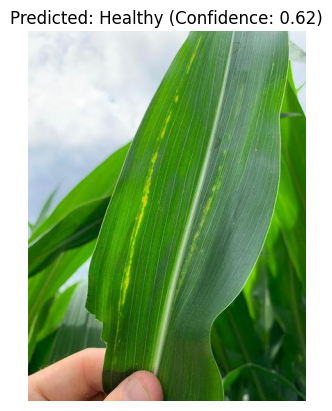

Predictions completed.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Buat batch tunggal
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Fungsi untuk memprediksi label gambar dan menampilkan hasil
def predict_image(model, img_path, class_names):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class

# Path ke folder gambar tes dan class names
class_names = ['Healthy', 'Common_rust', 'Gray_leaf_spot', 'Blight']  # Ganti dengan nama-nama kelas sesuai model Anda

# Memuat model
model.load_weights('best_model.keras')

# Mengunggah gambar
uploaded = files.upload()

# Inisialisasi list untuk menyimpan label asli dan prediksi
predicted_labels = []

# Menguji semua gambar yang diunggah
for img_name in uploaded.keys():
    img_path = img_name
    predicted_class = predict_image(model, img_path, class_names)
    predicted_labels.append(predicted_class)

print("Predictions completed.")


Saving 63c7c2f9ea5fd.jpg to 63c7c2f9ea5fd.jpg
1/1 [==============================] - 0s 53ms/step


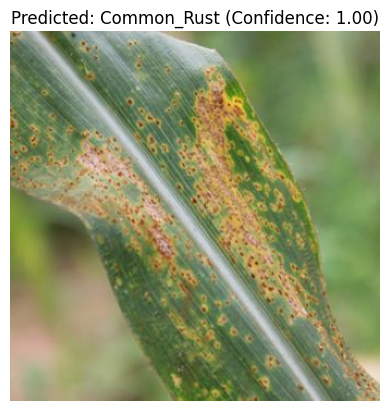

Predictions completed.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Buat batch tunggal
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Fungsi untuk memprediksi label gambar dan menampilkan hasil
def predict_image(model, img_path, class_names):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class

# Path ke folder gambar tes dan class names
class_names = ['Blight', 'Common_Rust', 'Gray_leaf_spot', 'Healthy']  # Ganti dengan nama-nama kelas sesuai model Anda

# Memuat model
model.load_weights('best_model.keras')

# Mengunggah gambar
uploaded = files.upload()

# Inisialisasi list untuk menyimpan label asli dan prediksi
predicted_labels = []

# Menguji semua gambar yang diunggah
for img_name in uploaded.keys():
    img_path = img_name
    predicted_class = predict_image(model, img_path, class_names)
    predicted_labels.append(predicted_class)

print("Predictions completed.")


Saving Corn_Common_Rust (1041).JPG to Corn_Common_Rust (1041).JPG
1/1 [==============================] - 0s 58ms/step


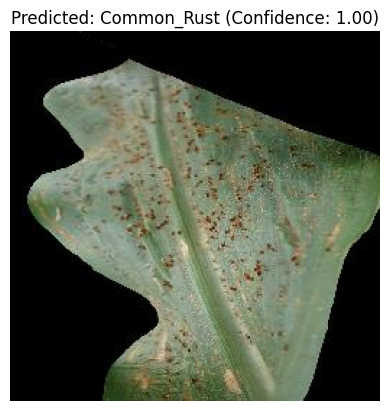

Predictions completed.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Buat batch tunggal
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Fungsi untuk memprediksi label gambar dan menampilkan hasil
def predict_image(model, img_path, class_names):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class

# Path ke folder gambar tes dan class names
class_names = ['Blight', 'Common_Rust', 'Gray_leaf_spot', 'Healthy']  # Ganti dengan nama-nama kelas sesuai model Anda

# Memuat model
model.load_weights('best_model.keras')

# Mengunggah gambar
uploaded = files.upload()

# Inisialisasi list untuk menyimpan label asli dan prediksi
predicted_labels = []

# Menguji semua gambar yang diunggah
for img_name in uploaded.keys():
    img_path = img_name
    predicted_class = predict_image(model, img_path, class_names)
    predicted_labels.append(predicted_class)

print("Predictions completed.")


Saving images.jpeg to images.jpeg
1/1 [==============================] - 0s 66ms/step


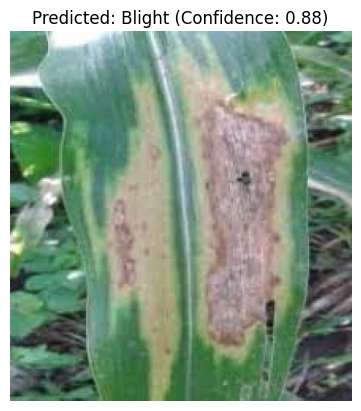

Predictions completed.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Buat batch tunggal
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Fungsi untuk memprediksi label gambar dan menampilkan hasil
def predict_image(model, img_path, class_names):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class

# Path ke folder gambar tes dan class names
class_names = ['Blight', 'Common_Rust', 'Gray_leaf_spot', 'Healthy']  # Ganti dengan nama-nama kelas sesuai model Anda

# Memuat model
model.load_weights('best_model.keras')

# Mengunggah gambar
uploaded = files.upload()

# Inisialisasi list untuk menyimpan label asli dan prediksi
predicted_labels = []

# Menguji semua gambar yang diunggah
for img_name in uploaded.keys():
    img_path = img_name
    predicted_class = predict_image(model, img_path, class_names)
    predicted_labels.append(predicted_class)

print("Predictions completed.")


Saving Corn_Health (1042).jpg to Corn_Health (1042).jpg
1/1 [==============================] - 0s 59ms/step


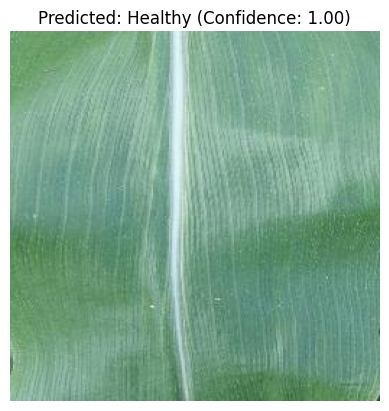

Predictions completed.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Buat batch tunggal
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Fungsi untuk memprediksi label gambar dan menampilkan hasil
def predict_image(model, img_path, class_names):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class

# Path ke folder gambar tes dan class names
class_names = ['Blight', 'Common_Rust', 'Gray_leaf_spot', 'Healthy']  # Ganti dengan nama-nama kelas sesuai model Anda

# Memuat model
model.load_weights('best_model.keras')

# Mengunggah gambar
uploaded = files.upload()

# Inisialisasi list untuk menyimpan label asli dan prediksi
predicted_labels = []

# Menguji semua gambar yang diunggah
for img_name in uploaded.keys():
    img_path = img_name
    predicted_class = predict_image(model, img_path, class_names)
    predicted_labels.append(predicted_class)

print("Predictions completed.")


Saving bacterial-leaf-streak-of-maize-maize-1583423390 (2).jpg to bacterial-leaf-streak-of-maize-maize-1583423390 (2).jpg
1/1 [==============================] - 0s 53ms/step


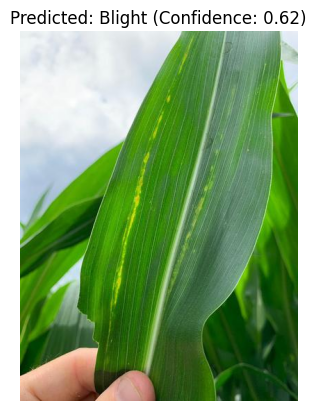

Predictions completed.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Buat batch tunggal
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Fungsi untuk memprediksi label gambar dan menampilkan hasil
def predict_image(model, img_path, class_names):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class

# Path ke folder gambar tes dan class names
class_names = ['Blight', 'Common_Rust', 'Gray_leaf_spot', 'Healthy']  # Ganti dengan nama-nama kelas sesuai model Anda

# Memuat model
model.load_weights('best_model.keras')

# Mengunggah gambar
uploaded = files.upload()

# Inisialisasi list untuk menyimpan label asli dan prediksi
predicted_labels = []

# Menguji semua gambar yang diunggah
for img_name in uploaded.keys():
    img_path = img_name
    predicted_class = predict_image(model, img_path, class_names)
    predicted_labels.append(predicted_class)

print("Predictions completed.")
